<a href="https://colab.research.google.com/github/NehaSontakk/BATH-Prokka-Comparison/blob/main/Length_analysis_TO_do_Aug5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install biopython

In [19]:
#Output files
prokka_annotations_save = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Prokka Output/Prokka_proteins_bin152.xlsx'
bath_dedup_annotations_save = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Deduplication Output/BATH_proteins_bin152.xlsx"
#Classifications
bath_prokka_alignment = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Aligned Outputs/Aligned_Outputs_bin152.xlsx"
#Fasta file
fasta_file = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Prokka Output/bin152.fna'

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import subprocess
import matplotlib.pyplot as plt
from Bio import SeqIO
from glob import glob
from pathlib import Path

In [21]:
prokka_proteins = pd.read_excel(prokka_annotations_save)
venn_data = pd.read_excel(bath_prokka_alignment)
bath_protein = pd.read_excel(bath_dedup_annotations_save)
bath_protein['seq_id'] = bath_protein['target name']
# Separate BATH data into positive and negative strands
pos_strand = bath_protein[bath_protein['strand'] == "+"].copy()
neg_strand = bath_protein[bath_protein['strand'] == "-"].copy()

# Handle columns for positive strand
pos_strand.loc[:, 'start'] = pos_strand['ali from'].astype(int)
pos_strand.loc[:, 'end'] = pos_strand['ali to'].astype(int)

# Handle columns for negative strand
neg_strand.loc[:, 'start'] = neg_strand['ali from flip'].astype(int)
neg_strand.loc[:, 'end'] = neg_strand['ali to flip'].astype(int)

# Filter Prokka proteins into positive and negative strands
prokka_proteins_plus = prokka_proteins[prokka_proteins['strand'] == '+'].copy()
prokka_proteins_minus = prokka_proteins[prokka_proteins['strand'] == '-'].copy()
bath_protein = pd.concat([pos_strand,neg_strand])

#### Area of annotation covered by Prokka

In [22]:
# Setup and Reading FASTA File
def read_fasta(file_path):
    contigs_list = []
    with open(file_path, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            contigs_list.append({'seq_id': record.id, 'length': len(record.seq)})
    return pd.DataFrame(contigs_list)

contigs_info = read_fasta(fasta_file)

# Filter Prokka proteins
def filter_proteins(proteins_df):
    annotated = proteins_df[proteins_df['product'] != 'hypothetical protein']
    non_annotated = proteins_df[proteins_df['product'] == 'hypothetical protein']
    return annotated, non_annotated

annotated_prokka_proteins, prodigal_orf = filter_proteins(prokka_proteins)

# Separate BATH data into positive and negative strands
def separate_strands(df):
    pos_strand = df[df['strand'] == "+"].copy()
    neg_strand = df[df['strand'] == "-"].copy()
    pos_strand['start'], pos_strand['end'] = pos_strand['ali from'].astype(int), pos_strand['ali to'].astype(int)
    neg_strand['start'], neg_strand['end'] = neg_strand['ali from flip'].astype(int), neg_strand['ali to flip'].astype(int)
    return pd.concat([pos_strand, neg_strand])

bath_protein = separate_strands(bath_protein)
bath_protein['seq_id'] = bath_protein['target name']

# Calculate covered length
def calculate_covered_length(df, seq_id):
    covered_points = set()
    for _, row in df[df['seq_id'] == seq_id].iterrows():
        covered_points.update(range(row['start'], row['end'] + 1))
    return len(covered_points)


In [23]:
contigs_info['total_prodigal'] = 0
contigs_info['total_covered_prokka'] = 0
contigs_info['total_covered_bath'] = 0
contigs_info['total_uncovered_prokka'] = 0
contigs_info['total_uncovered_bath'] = 0
contigs_info['contig_length'] = 0

for _, contig in contigs_info.iterrows():
    seq_id = contig['seq_id']
    contig_length = contig['length']

    total_prodigal = calculate_covered_length(prodigal_orf, seq_id)
    total_covered_prokka = calculate_covered_length(annotated_prokka_proteins, seq_id)
    total_covered_bath = calculate_covered_length(bath_protein, seq_id)

    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_prodigal'] = total_prodigal
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_covered_prokka'] = total_covered_prokka
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_covered_bath'] = total_covered_bath
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'contig_length'] = contig['length']


contigs_info['percent_covered_prokka'] = (contigs_info['total_covered_prokka'] / contigs_info['contig_length']) * 100
contigs_info['percent_covered_prodigal'] = (contigs_info['total_prodigal'] / contigs_info['contig_length']) * 100
contigs_info['percent_uncovered_prokka'] = 100 - contigs_info['percent_covered_prokka'] - contigs_info['percent_covered_prodigal']

contigs_info['percent_covered_bath'] = (contigs_info['total_covered_bath'] / contigs_info['contig_length']) * 100
contigs_info['percent_uncovered_bath'] = 100 - contigs_info['percent_covered_bath']

## How much of the contig is covered by BATH vs Prokka?

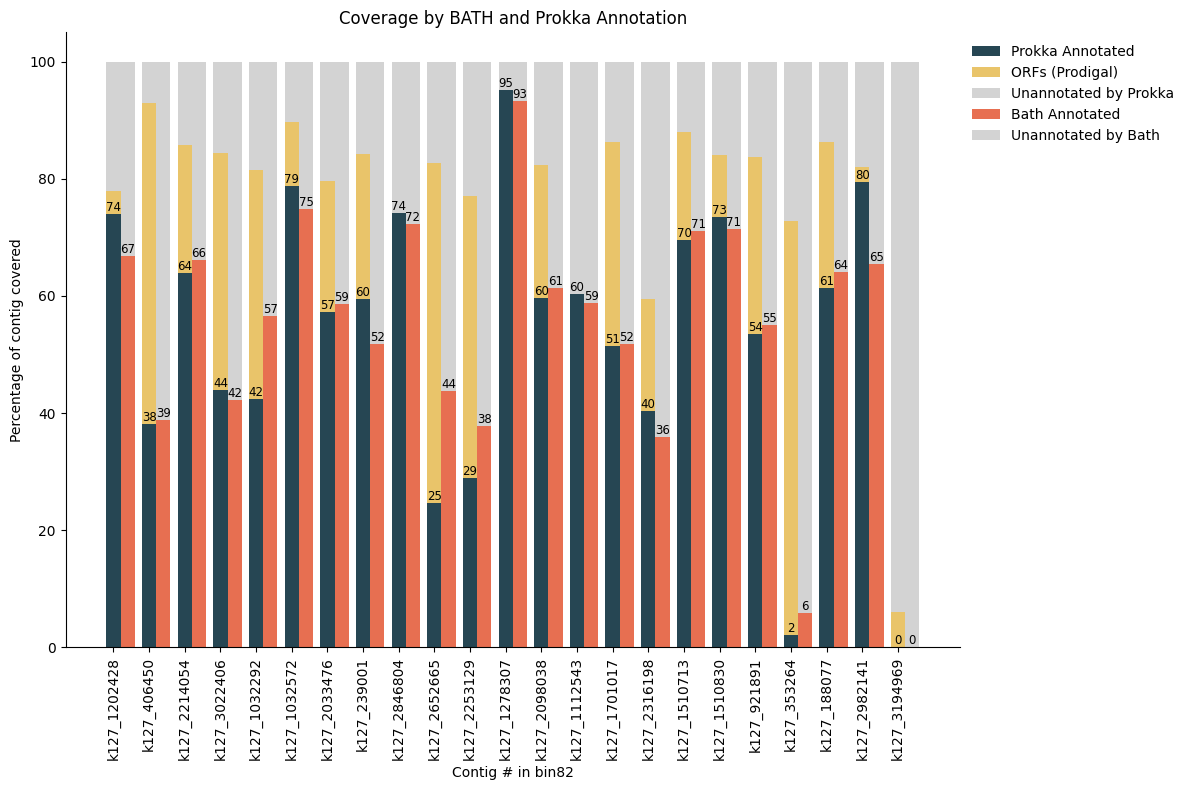

In [24]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))
n_contigs = len(contigs_info)
index = range(n_contigs)
bar_width = 0.4

bar2 = ax.bar(index, contigs_info['percent_covered_prokka'], bar_width, label='Prokka Annotated',color="#264653")
bar1 = ax.bar(index, contigs_info['percent_covered_prodigal'], bar_width, bottom=contigs_info['percent_covered_prokka'], label='ORFs (Prodigal)',color='#E9C46A')
bar3 = ax.bar(index, contigs_info['percent_uncovered_prokka'], bar_width, bottom=contigs_info['percent_covered_prodigal']+contigs_info['percent_covered_prokka'], label='Unannotated by Prokka',color='lightgrey')

bar4 = ax.bar([p + bar_width for p in index], contigs_info['percent_covered_bath'], bar_width, label='Bath Annotated',color="#E76F51")
bar5 = ax.bar([p + bar_width for p in index], contigs_info['percent_uncovered_bath'], bar_width, bottom=contigs_info['percent_covered_bath'], label='Unannotated by Bath',color='lightgrey')

for rect in bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{round(height)}', ha='center', va='bottom',fontsize=8.5)

for rect in bar4:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{round(height)}', ha='center', va='bottom',fontsize=8.5)

ax.set_xlabel('Contig # in bin82')
ax.set_ylabel('Percentage of contig covered')
ax.set_title('Coverage by BATH and Prokka Annotation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)  # Ensure left line is visible
indices = range(n_contigs)
ax.set_xticks(indices)
ax.set_xticklabels(contigs_info['seq_id'], rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()

## How many annotations are generated by BATH vs Prokka?

In [25]:
def calculate_num_annotations(annotation_df, contig_id):
    annotations = annotation_df[annotation_df['seq_id'] == contig_id]
    return len(annotations)

# Initialize a list to hold results
results = []

for _, contig in contigs_info.iterrows():
    seq_id = contig['seq_id']

    # Calculate number of annotations for Prokka and BATH
    num_annotations_prokka = calculate_num_annotations(annotated_prokka_proteins, seq_id)
    num_annotations_bath = calculate_num_annotations(bath_protein, seq_id)

    results.append({
        'seq_id': seq_id,
        'Prokka Annotations Count': num_annotations_prokka,
        'BATH Annotations Count': num_annotations_bath
    })

    print(f"Contig {seq_id}: Prokka Annotations = {num_annotations_prokka}, BATH Annotations = {num_annotations_bath}")

# Convert results to DataFrame for easier manipulation and visualization
results_df = pd.DataFrame(results)
print(results_df)

Contig k127_1202428: Prokka Annotations = 10, BATH Annotations = 10
Contig k127_406450: Prokka Annotations = 9, BATH Annotations = 12
Contig k127_2214054: Prokka Annotations = 19, BATH Annotations = 26
Contig k127_3022406: Prokka Annotations = 15, BATH Annotations = 19
Contig k127_1032292: Prokka Annotations = 11, BATH Annotations = 17
Contig k127_1032572: Prokka Annotations = 95, BATH Annotations = 102
Contig k127_2033476: Prokka Annotations = 51, BATH Annotations = 63
Contig k127_239001: Prokka Annotations = 69, BATH Annotations = 74
Contig k127_2846804: Prokka Annotations = 5, BATH Annotations = 6
Contig k127_2652665: Prokka Annotations = 2, BATH Annotations = 5
Contig k127_2253129: Prokka Annotations = 6, BATH Annotations = 9
Contig k127_1278307: Prokka Annotations = 17, BATH Annotations = 17
Contig k127_2098038: Prokka Annotations = 14, BATH Annotations = 23
Contig k127_1112543: Prokka Annotations = 1, BATH Annotations = 1
Contig k127_1701017: Prokka Annotations = 8, BATH Annotati

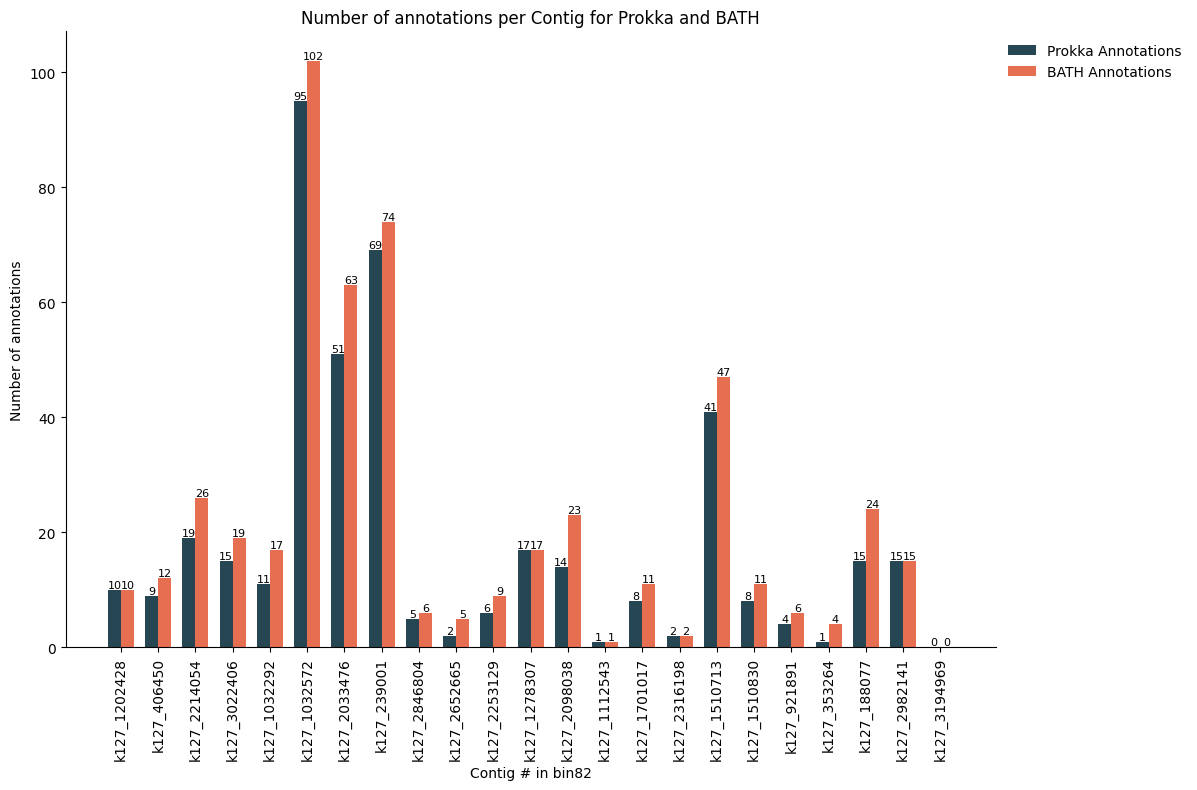

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
n_contigs = len(results_df)
index = range(n_contigs)
bar_width = 0.35

# Creating bars for Prokka annotations
prokka_bars = ax.bar(index, results_df['Prokka Annotations Count'], bar_width, label='Prokka Annotations', color="#264653")

# Creating bars for BATH annotations, offset by bar_width for side-by-side bars
bath_bars = ax.bar([p + bar_width for p in index], results_df['BATH Annotations Count'], bar_width, label='BATH Annotations', color="#E76F51")

# Adding text labels above the bars
for rect in prokka_bars:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=8)

for rect in bath_bars:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)  # Ensure left line is visible
ax.set_xlabel('Contig # in bin82')
ax.set_ylabel('Number of annotations')
ax.set_title('Number of annotations per Contig for Prokka and BATH')
ax.set_xticks([p + bar_width / 2 for p in index])  # Positioning the tick in the middle of the grouped bars
ax.set_xticklabels(results_df['seq_id'], rotation=90)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.show()


How much of a contig is covered by BATH compared to Prokka? (Fancier plot)

In [27]:
def calculate_length_and_contig(annotation):
    if pd.isna(annotation):
        return None, None
    parts = annotation.split('\t')
    contig = parts[0]
    start = int(parts[1])
    end = int(parts[2])
    length = abs(end - start)
    return length, contig

# Apply the function to the BATH column
venn_data[['BATH length', 'contig_bath']] = venn_data['BATH'].apply(lambda x: pd.Series(calculate_length_and_contig(x)))

# Apply the function to the Prokka column
venn_data[['Prokka length', 'contig_prokka']] = venn_data['Prokka'].apply(lambda x: pd.Series(calculate_length_and_contig(x)))

# Fill missing values in contig_bath with contig_prokka and vice versa to create a single contig column
venn_data['contig'] = venn_data['contig_bath'].combine_first(venn_data['contig_prokka'])

# Drop the intermediate contig columns
venn_data = venn_data.drop(columns=['contig_bath', 'contig_prokka'])

# Merge with contigs_info to get the full length of each contig
venn_data = venn_data.merge(contigs_info, left_on='contig', right_on='seq_id', how='left').drop(columns=['seq_id'])

# Calculate the sum of lengths grouped by label and contig
grouped_sum = venn_data.groupby(['label', 'contig', 'length'])[['BATH length', 'Prokka length']].sum().reset_index()

# Calculate the total annotated length
grouped_sum['total_annotated_length'] = grouped_sum['BATH length'] + grouped_sum['Prokka length']

# Calculate the percentage covered by each label
grouped_sum['percentage_covered'] = (grouped_sum['total_annotated_length'] / grouped_sum['length']) * 100

# Calculate the unannotated percentage for each contig
unannotated = grouped_sum.groupby('contig')['percentage_covered'].sum().reset_index()
unannotated['unannotated_percentage'] = 100 - unannotated['percentage_covered']
unannotated = unannotated[['contig', 'unannotated_percentage']]

# Add unannotated to the grouped_sum
unannotated['label'] = 'Unannotated'
unannotated['BATH length'] = 0
unannotated['Prokka length'] = 0
unannotated = unannotated.rename(columns={'unannotated_percentage': 'percentage_covered'})
grouped_sum = pd.concat([grouped_sum, unannotated], ignore_index=True)

# Pivot the DataFrame
pivot_df = grouped_sum.pivot_table(index='contig', columns='label', values='percentage_covered', fill_value=0)

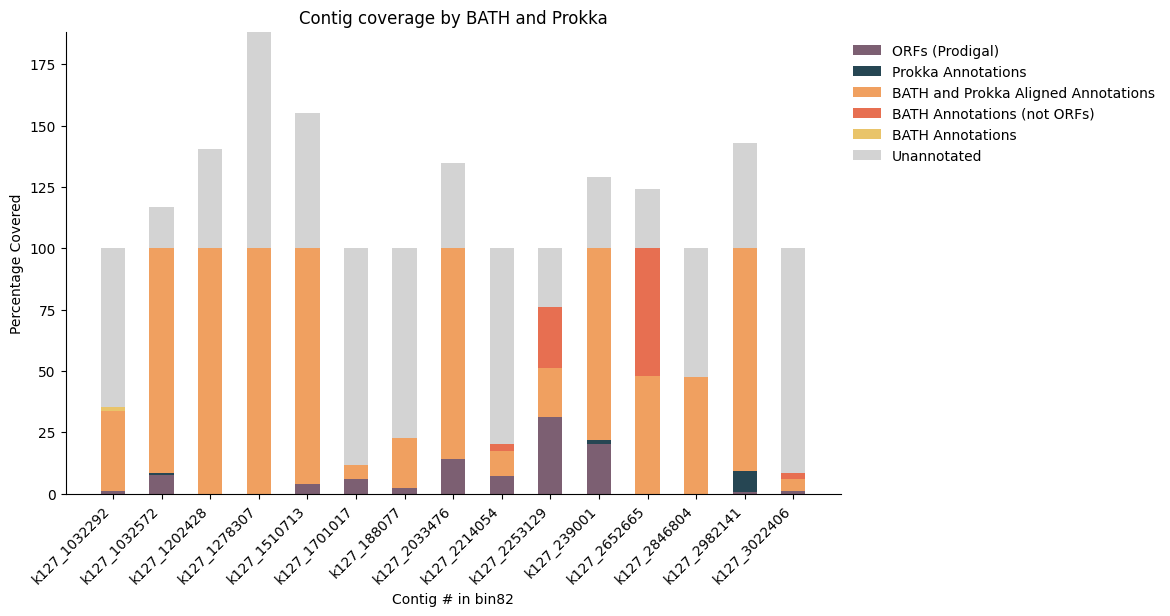

In [28]:

plt.style.use('default')
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar positions
bar_width = 0.5
bar_positions = range(len(pivot_df))

# Plot each segment
bottoms = [0] * len(pivot_df)


label_order = ['Prokka Unannotated','Prokka Annotated','BATH and Prokka Annotated', 'BATH and Prokka Unannotated', 'BATH', 'Unannotated']
custom_labels = {
    'BATH and Prokka Annotated': 'BATH and Prokka Aligned Annotations',
    'Prokka Unannotated': 'ORFs (Prodigal)',
    'BATH and Prokka Unannotated': 'BATH Annotations (not ORFs)',
    'BATH': 'BATH Annotations',
    'Unannotated': 'Unannotated',
    'Prokka Annotated':'Prokka Annotations'
}

# Pivot the DataFrame with the specified order
pivot_df = grouped_sum.pivot_table(index='contig', columns='label', values='percentage_covered', fill_value=0).reindex(columns=label_order, fill_value=0)

# Rename the columns with custom labels
pivot_df.columns = [custom_labels[label] for label in pivot_df.columns]

colors = ['#7C5F72', '#264653', '#f0a060', '#E76F51', '#E9C46A', '#D3D3D3']  # Custom colors including gray for unannotated

for i, label in enumerate(pivot_df.columns):
    ax.bar(bar_positions, pivot_df[label], bottom=bottoms, width=bar_width, label=label, color=colors[i % len(colors)])
    bottoms = [bottoms[j] + pivot_df[label].iloc[j] for j in range(len(pivot_df))]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)  # Ensure left line is visible
ax.set_xlabel('Contig # in bin82')
ax.set_xticks(bar_positions)
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
ax.set_ylabel('Percentage Covered')
ax.set_title('Contig coverage by BATH and Prokka')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'venn_data' is already loaded as a DataFrame

# Group the data
grouped_sum = venn_data.groupby(['label', 'contig']).size().reset_index(name='count')

# Create a pivot table
pivot_df = grouped_sum.pivot_table(index='contig', columns='label', values='count', fill_value=0)

# Define the order and colors for the annotations
order_bar1 = ['BATH and Prokka Annotated', 'BATH and Prokka Unannotated', 'BATH']
order_bar2 = ['BATH and Prokka Annotated','Prokka Annotated']

colors = {
    'BATH': '#E76F51',
    'BATH and Prokka Annotated': '#7C5F72',
    'BATH and Prokka Unannotated': '#F4A261',
    'Prokka Annotated': '#264653'
}

custom_labels = {
    'BATH and Prokka Annotated': 'BATH and Prokka Aligned Annotations',
    'Prokka Unannotated': 'ORFs (Prodigal)',
    'BATH and Prokka Unannotated': 'BATH Annotations (not ORFs)',
    'BATH': 'BATH Annotations',
    'Unannotated': 'Unannotated',
    'Prokka Annotated': 'Prokka Annotations'
}

# Separate the data for the two bars
bar1_data = pivot_df[order_bar1]
bar2_data = pivot_df[order_bar2]

# Plot the data as stacked bar charts
fig, ax = plt.subplots(figsize=(14, 8))

# Define the positions for the bars with a small gap between them within each group
bar_width = 0.35
group_width = 1.0  # Width of the space for each group of bars
bar_positions1 = np.arange(len(pivot_df)) * group_width
bar_positions2 = bar_positions1 + bar_width + 0.03  # Adding a small gap between bar 1 and bar 2

# Plot Bar 1
bottoms1 = [0] * len(pivot_df)
for label in order_bar1:
    ax.bar(bar_positions1, bar1_data[label], bottom=bottoms1, width=bar_width, label=custom_labels[label] if custom_labels[label] not in ax.get_legend_handles_labels()[1] else "", color=colors[label])
    bottoms1 = [bottoms1[i] + bar1_data[label][i] for i in range(len(pivot_df))]

# Plot Bar 2
bottoms2 = [0] * len(pivot_df)
for label in order_bar2:
    ax.bar(bar_positions2, bar2_data[label], bottom=bottoms2, width=bar_width, label=custom_labels[label] if custom_labels[label] not in ax.get_legend_handles_labels()[1] else "", color=colors[label])
    bottoms2 = [bottoms2[i] + bar2_data[label][i] for i in range(len(pivot_df))]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_title('Number of annotations per contig by BATH and Prokka')
ax.set_ylabel('Counts')
ax.set_xlabel('Contig # in bin82')
ax.set_xticks(bar_positions1 + bar_width / 2 + 0.025)
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()


### Plotting length distributions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to extract lengths
def extract_length(annotation):
    if pd.isna(annotation):
        return 0
    parts = annotation.split('\t')
    start = int(parts[1])
    end = int(parts[2])
    return end - start + 1

# Calculate lengths and store in lists
lengths = []
labels = []
annotation_type = []

for _, row in venn_data.iterrows():
    prokka_length = extract_length(row['Prokka'])
    bath_length = extract_length(row['BATH'])

    if prokka_length > 0:
        lengths.append(prokka_length)
        labels.append(row['label'])
        annotation_type.append('Prokka')
    if bath_length > 0:
        lengths.append(bath_length)
        labels.append(row['label'])
        annotation_type.append('BATH')

# Create a DataFrame for plotting
lengths_df = pd.DataFrame({
    'Length': lengths,
    'Label': labels,
    'Annotation': annotation_type
})

# Combine 'Label' and 'Annotation' for hue
lengths_df['Label_Annotation'] = lengths_df['Label'] + ' (' + lengths_df['Annotation'] + ')'

In [ ]:
lengths_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


palette = {
    'Prokka Unannotated (Prokka)': '#E9C46A',
    'Prokka Annotated (Prokka)': '#264653',
    'BATH and Prokka Annotated (BATH)': '#CBC3E3',
    'BATH and Prokka Annotated (Prokka)': '#7C5F72',
    'BATH and Prokka Unannotated (BATH)': '#F4A261',
    'BATH and Prokka Unannotated (Prokka)': '#E9C46A',
    'BATH (BATH)': '#E76F51'
}

custom_labels = ['ORFs (Prodigal)', 'Prokka Annotations', 'BATH Annotations (not ORF)', 'BATH and Prokka\nAligned Annotations', 'BATH Annotations (ORFs)']

custom_labels2 = ['ORFs (Prodigal)', 'Prokka Annotations', 'BATH Annotations (not ORF)', 'BATH and Prokka\nAligned Annotations (Prokka)', 'BATH and Prokka\nAligned Annotations (BATH)', 'ORFs (Prodigal)', 'BATH Annotations (ORFs)']

plt.style.use('default')
fig, ax = plt.subplots(figsize=(15, 8))

# Define the order for labels and annotations
label_order = lengths_df['Label'].unique().tolist()
annotation_order = lengths_df['Annotation'].unique().tolist()

sns.stripplot(x='Label', y='Length', hue='Label_Annotation', data=lengths_df, dodge=True, jitter=True, alpha=0.5, edgecolor='black', linewidth=0.5, ax=ax, palette=palette)
#sns.boxplot(x='Label', y='Length', hue='Label_Annotation', data=lengths_df, palette=palette, ax=ax)


sns.boxplot(x='Label', y='Length', hue='Label_Annotation', data=lengths_df, palette=palette, ax=ax, width=0.8)


# Customize the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_title('Length distributions of Prokka vs BATH annotations')
ax.set_xlabel('Annotation Source')
ax.set_ylabel('Length of Individual Annotations')
ax.set_xticklabels(custom_labels, rotation=45, ha='right')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), custom_labels2, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
def parse_prokka(row):
    if pd.isna(row):
        return np.nan

    parts = row.split('\t')
    last_element = parts[-1]

    if 'UniProt' in last_element:
        return 'Blast'
    elif 'IS' in last_element:
        return 'ISFinder'
    elif 'MF' in last_element:
        return 'HMMER'
    else:
        return 'Prodigal'

# Apply the function to the 'Prokka' column and create the new 'Prokka_SW' column
venn_data['Prokka_SW'] = venn_data['Prokka'].apply(parse_prokka)

print(venn_data['Prokka_SW'])

In [ ]:
filtered_data = venn_data.dropna(subset=['BATH length', 'Prokka length', 'Prokka_SW'])

# Define the pastel palette with the requested colors
palette2 = {'Blast': '#FFB7B2', 'ISFinder': '#FDE293', 'HMMER': '#B2D8B2', 'Prodigal': '#9BB7C7'}

# Plot the data
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='BATH length', y='Prokka length', hue='Prokka_SW', data=filtered_data, palette=palette2, s=100, alpha=0.7, edgecolor='black')

# Plot the 45-degree line
max_length = max(filtered_data['BATH length'].max(), filtered_data['Prokka length'].max())
plt.plot([0, max_length], [0, max_length], color='black', linestyle='--', linewidth=1)
plt.xlim(0, 6000)
plt.ylim(0, 6000)
plt.title('Length comparison of BATH and Prokka aligned annotations')
plt.xlabel('BATH annotation length')
plt.ylabel('Prokka annotation length')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.legend(title='Prokka Annotation\n Origin', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

In [ ]:
venn_data.to_excel("Size_check.xlsx")

### Checking frameshifts for every group

In [ ]:
bath_data = venn_data[(venn_data['label'] != "Prokka Annotated") & (venn_data['label'] != "Prokka Unannotated")]

In [ ]:
shifts = []
for index, rows in bath_data.iterrows():
  shifts.append(rows['BATH'].split("\t")[-1])

In [ ]:
frameshifts = pd.DataFrame()
frameshifts['label'] = bath_data['label']
frameshifts['shifts'] = shifts
frameshifts['shifts'] = frameshifts['shifts'].astype(int)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
fig, ax = plt.subplots(figsize=(14, 8))

palette = {
    'Prokka Unannotated': '#E9C46A',
    'Prokka Annotated ': '#264653',
    'BATH and Prokka Annotated': '#7C5F72',
    'BATH and Prokka Unannotated': '#F4A261',
    'BATH': '#E76F51'
}

sns.violinplot(x='label', y='shifts', data=frameshifts, inner=None, palette=palette, ax=ax)
sns.stripplot(x='label', y='shifts', data=frameshifts, color='grey', edgecolor='black', linewidth=0.5, ax=ax, alpha=0.5)

# Calculate and plot median and quartiles
medians = frameshifts.groupby(['label'])['shifts'].median()
quartiles = frameshifts.groupby(['label'])['shifts'].quantile([0.25, 0.75]).unstack()

for idx, median in enumerate(medians):
    plt.axhline(median, color='black', linestyle='--', linewidth=1)
    plt.text(idx, median, f'{median:.1f}', ha='center', va='center', color='white', fontweight='bold')

for idx, quartile in enumerate(quartiles.itertuples(index=False, name=None)):
    plt.axhline(quartile[0], color='black', linestyle='--', linewidth=0.5)
    plt.axhline(quartile[1], color='black', linestyle='--', linewidth=0.5)

custom_labels = ['BATH Annotations(not ORFs)','BATH and Prokka \n Aligned Annotations','BATH annotations (ORFs)']
ax.set_xticklabels(custom_labels, rotation=45, ha='right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)
ax.set_title('Frameshifts for each BATH annotation')
ax.set_xlabel('BATH annotation sets')
ax.set_ylabel('# of frameshifts')

plt.legend()
plt.show()
